# Is a Quantum Kernel Worth Exploring? A '$g$-first' Reality Check

Can we predict—*before* investing a ton of research hours- whether a quantum kernel has the potential to beat a classical one across all kernel methods?

From a practitioner's perspective, such a **pre-screening test** is invaluable: it lets us rule out quantum kernels that don't offer any potential quantum advantage right from the start.

Huang *et al.* (https://arxiv.org/abs/2011.01938) introduced exactly this test. Their proposed **geometric difference $g$** metric is a single scalar that quantifies how differently the geometries defined by two kernels represent your data. The formula for $g$ is:

$g = \sqrt{\|\sqrt{K_q} K_c^{-1} \sqrt{K_q}\|_\infty}$

where $K_q$ and $K_c$ are quantum and classical Gram matrices, respectively.

## Kernel Refresher

A **kernel** is a function $k(x, x')$ that measures similarity between data points without explicitly computing their feature representations in high-dimensional spaces, thus lowering the computational cost.

### Classical Kernels
- Example: RBF (Radial Basis Function) kernel
- Formula: $k(x, x') = \exp(-\gamma \|x - x'\|^2)$
- Implicitly computes: $k(x, x') = \langle\phi(x), \phi(x')\rangle$
- The feature map $\phi(x)$ projects to infinite dimensions but is never calculated directly

### Quantum Kernels
- Formula: $k(x, x') = |\langle\psi(x)|\psi(x')\rangle|^2$
- $|\psi(x)\rangle$ is the quantum state encoding the classical data $x$
- For $n$ qubits, the quantum state lives in a $2^n$-dimensional Hilbert space that is implicitly manipulated

### Key Concepts
The **kernel matrix** (Gram matrix) $K$ has entries $K_{ij} = k(x_i, x_j)$ that store all pairwise similarities between data points.


## What $g$ tells us:
* **If $g$ ≈ 1**: The quantum kernel's geometry is essentially the same as a good classical kernel's → the quantum kernel offers no geometric advantage, making it unlikely to outperform the classical kernel **in any kernel-based learning algorithm** (e.g., SVM, Gaussian Processes). Huang et al. proved this concept in a rigorous mathematical way in their paper. 

* **If $g$ ≫ 1**: The quantum geometry is genuinely different → **a kernel method using the quantum kernel** *might* offer an advantage.

## Why this matters:

This approach focuses on ruling out underperforming quantum kernels before investing in training. From a complexity theory point of view, computing $g$ scales as $O(n^3)$ due to the matrix inversion, and the most expensive training algorithms such as Gaussian Processes also scale as $O(n^3)$ so we might think we are not saving any computational time. However, from a practical perspective, the real savings come from avoiding wasted researcher effort.

When a quantum kernel performs poorly, researchers often spend days exploring different algorithm hyperparameters, cross-validation strategies, and implementation debugging. If $g \approx 1$, you immediately know the quantum kernel's geometry offers no advantage---it's not your implementation, not your algorithm choice, and not a hyperparameter issue. The kernel is fundamentally limited compared to classical kernels on this specific dataset.

## Demonstration setup:
1. **Dataset**: Synthetic two-moons data generated with `scikit-learn`
2. **Five kernels to compare**:
   * **Classical baseline**: Gaussian-RBF kernel
   * **Quantum kernels**:
     * Separable-rotation embedding (E1)
     * IQP-style embedding (E2)
     * Projected kernel from E1 (maximizing $g$ as proposed by Huang et al.)
     * Projected kernel from E2
3. **Our approach**: Calculate $g$ values between the classical kernel and each quantum kernel—giving us an immediate assessment of which quantum approaches might be worth pursuing across any kernel-based method

Train size: 210    Test size: 90


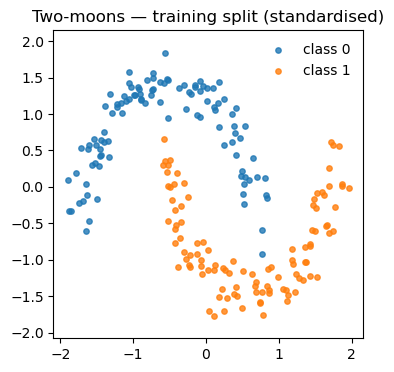

In [1]:
# We first start by generating and visualizing the artificial data
import numpy as np
import matplotlib.pyplot as plt
import scipy 

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(422)

X_raw, y = make_moons(n_samples=300, noise=0.10, random_state=0)

# train/test split BEFORE any scaling (avoid data leakage) ------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.30, random_state=0, stratify=y
)

# standardize the data
scaler = StandardScaler().fit(X_train_raw)  # statistics from train only
X_train = scaler.transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

print(f"Train size: {X_train.shape[0]}    Test size: {X_test.shape[0]}")

# visualize it using a scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            s=15, alpha=0.8, label="class 0")
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            s=15, alpha=0.8, label="class 1")
plt.axis("equal")
plt.title("Two‑moons — training split (standardised)")
plt.legend(frameon=False)
plt.show()

### Quantum kernels: fidelity-based and projected variants

We consider **five different kernels**, derived from three sources: a classical RBF kernel and two quantum embedding circuits — **E1** and **E2**.  
Each kernel defines a different geometry for measuring similarity between data points.

- **RBF – Classical radial basis function kernel**  
  A classical baseline defined as:  
  $$
  k_{\text{RBF}}(x, x') = \exp(-\gamma \|x - x'\|^2)
  $$
  This maps data into an infinite-dimensional space where closer inputs remain close, and distant ones become nearly orthogonal.  
  It captures a **geometric**, distance-based notion of similarity in input space.


- **E1 – Separable RX rotations**  
  Each input feature $x_j$ is encoded into a single qubit using an $RX(x_j)$ gate.  
  The circuit is fully separable (no entanglement), producing the quantum state $\lvert \psi_{\text{E1}}(x) \rangle$.

- **E2 – IQP embedding**  
  PennyLane’s `qml.IQPEmbedding` applies Hadamards, parameterized $RZ(x_j)$ rotations, and entangling ZZ gates.  
  This creates an entangled quantum state $\lvert \psi_{\text{E2}}(x) \rangle$, inspired by Instantaneous Quantum Polynomial (IQP) circuits.

- **QK – Standard quantum kernels**  
  For both E1 and E2, the kernel is defined by the **fidelity** between quantum states: 
  $$ 
  k_{\text{QK-E1}}(x, x') = |\langle \psi_{\text{E1}}(x) \mid \psi_{\text{E1}}(x') \rangle|^2
  $$
  $$
  k_{\text{QK-E2}}(x, x') = |\langle \psi_{\text{E2}}(x) \mid \psi_{\text{E2}}(x') \rangle|^2
  $$

  where $\psi_{\text{E1}}(x)$ and $\psi_{\text{E2}}(x)$ are the quantum states generated by E1 and E2 respectively.
  These kernels reflect how aligned two quantum feature states are in Hilbert space.

- **PQK – Projected quantum kernels (PQK-E1 / PQK-E2)**  
  For a projected quantum kernel, instead of computing fidelity, the output quantum state $|\psi(x)\rangle$  
  is **measured** to extract the expectation values of Pauli operators:  
  $$
  v(x) = \left[ \langle X_0 \rangle, \langle Y_0 \rangle, \langle Z_0 \rangle, \dots, \langle Z_{n-1} \rangle \right]
  $$
  A classical **RBF kernel** is then applied to these real-valued vectors:  
  $$
  k_{\text{PQK}}(x, x') = \exp\left( -\gamma \| v(x) - v(x') \|^2 \right)
  $$
  We obtain two different projected quantum kernels from E1 and E1:

  $$
  k_{\text{PQK-E1}}(x, x') = \exp\left( -\gamma \|v_{\text{E1}}(x) - v_{\text{E1}}(x')\|^2 \right)
  $$

  $$
  k_{\text{PQK-E2}}(x, x') = \exp\left( -\gamma \|v_{\text{E2}}(x) - v_{\text{E2}}(x')\|^2 \right)
  $$
  where $v_{\text{E1 }}(x)$ and $v_{\text{E2}}(x)$ are the Pauli expectation vector from E1 and E2 respectively.



E1 Embedding Circuit:


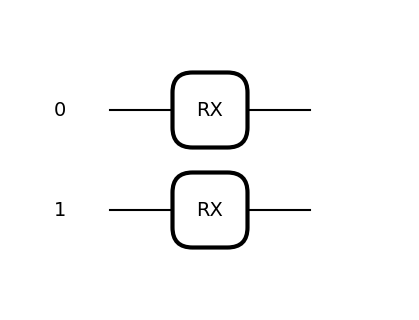


E2 Embedding Circuit:


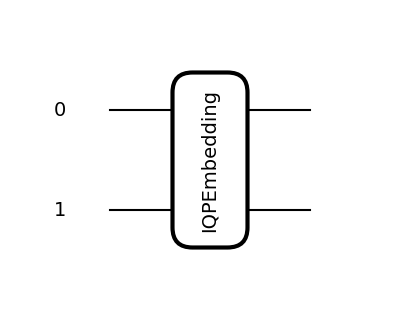

In [2]:
# We define the embedding circuits E1 and E2, and we visualize them.
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

n_features = X_train.shape[1]
n_qubits   = n_features

# -- E1: separable RX rotations ---------------------------------------------
def embedding_E1(features):
    for j, xj in enumerate(features):
        qml.RX(np.pi * xj, wires=j)

# -- E2: IQP embedding via PennyLane template --------------------------------
def embedding_E2(features):
    qml.IQPEmbedding(features, wires=range(n_features))

print("E1 Embedding Circuit:")
fig, ax = qml.draw_mpl(embedding_E1)(np.zeros(n_qubits))
plt.show()

print("\nE2 Embedding Circuit:")
fig, ax = qml.draw_mpl(embedding_E2)(np.zeros(n_qubits))
plt.show()

### Gram Matrix Computation

Using the kernels defined above, we now build the **Gram (kernel) matrices** required to compute the practitioner's metric $g$.

For a dataset of $N$ samples and a kernel function $k(\cdot, \cdot)$, the Gram matrix $K \in \mathbb{R}^{N \times N}$ is defined entrywise as:
$$
K_{ij} = k(x_i, x_j)
$$

Each entry $K_{ij}$ measures how similar two data points are, and the full matrix $K$ provides a **global view** of the data in the kernel's feature space.

We compute five such matrices, one for each kernel defined above:

$K_{\text{RBF}}$ obtained from:
$$
k_{\text{RBF}}(x, x') = \exp(-\gamma \|x - x'\|^2)
$$

$K_{\text{QK-E1}}$ obtained from:
$$
k_{\text{QK-E1}}(x, x') = |\langle \psi_{\text{E1}}(x) \mid \psi_{\text{E1}}(x') \rangle|^2
$$

$K_{\text{QK-E2}}$ obtained from:
$$
k_{\text{QK-E2}}(x, x') = |\langle \psi_{\text{E2}}(x) \mid \psi_{\text{E2}}(x') \rangle|^2
$$

$K_{\text{PQK-E1}}$ obtained from:
$$
k_{\text{PQK-E1}}(x, x') = \exp\left( -\gamma \|v_{\text{E1}}(x) - v_{\text{E1}}(x')\|^2 \right)
$$

$K_{\text{PQK-E2}}$ obtained from:
$$
k_{\text{PQK-E2}}(x, x') = \exp\left( -\gamma \|v_{\text{E2}}(x) - v_{\text{E2}}(x')\|^2 \right)
$$

The gram matrices will be used in downstream evaluations to compare kernel geometries and analyze expressivity and generalization metrics like $g$.

In [3]:
# The following code builds all five Gram (kernel) matrices: Classical, QK-E1, QK-E2, PQK-E1, PQK-E2
from sklearn.metrics.pairwise import rbf_kernel

# ---------------------------------------------------------------------------#
# Classical RBF Gram matrix                                                  #
# ---------------------------------------------------------------------------#
def classical_rbf_kernel(X, gamma=1.0):
    return rbf_kernel(X, gamma=gamma)

K_classical = classical_rbf_kernel(X_train)
print(f"K_RBF shape: {K_classical.shape}")

# ---------------------------------------------------------------------------#
# Quantum fidelity-based Gram matrices                                       #
# ---------------------------------------------------------------------------#
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

def overlap_prob(x, y, embed):
    """Probability of measuring |0…0⟩ after U(x) U†(y)."""
    @qml.qnode(dev)
    def circuit():
        embed(x)
        qml.adjoint(embed)(y)
        return qml.probs(wires=range(n_qubits))
    return circuit()[0]

def quantum_kernel_matrix(X, embed):
    return qml.kernels.kernel_matrix(
        X, X, lambda v1, v2: overlap_prob(v1, v2, embed)
    )

print("Computing QK-E1 (fidelity)...")
K_quantum_E1 = quantum_kernel_matrix(X_train, embed=embedding_E1)

print("Computing QK-E2 (fidelity)...")
K_quantum_E2 = quantum_kernel_matrix(X_train, embed=embedding_E2)

print(f"K_QK_E1 shape: {K_quantum_E1.shape}")
print(f"K_QK_E2 shape: {K_quantum_E2.shape}")

# ---------------------------------------------------------------------------#
# Projected quantum kernels (Pauli vectors + classical RBF)                  #
# ---------------------------------------------------------------------------#
def get_pauli_vectors(embedding_func, X):
    """Returns Pauli expectation vectors for each input using the given embedding."""
    observables = []
    for i in range(n_qubits):
        observables.extend([qml.PauliX(i), qml.PauliY(i), qml.PauliZ(i)])

    @qml.qnode(dev)
    def pauli_qnode(x):
        embedding_func(x)
        return [qml.expval(obs) for obs in observables]

    vectors = [pauli_qnode(x) for x in X]
    return np.array(vectors)

def calculate_gamma(vectors):
    """Use heuristic gamma = 1 / (d * var) for RBF kernel on Pauli space."""
    d = vectors.shape[1]
    var = np.var(vectors)
    return 1.0 / (d * var) if var > 1e-8 else 1.0

def pqk_kernel_matrix(X, embedding_func):
    """Computes PQK kernel matrix from Pauli vectors + RBF kernel."""
    pauli_vecs = get_pauli_vectors(embedding_func, X)
    gamma = calculate_gamma(pauli_vecs)
    return rbf_kernel(pauli_vecs, gamma=gamma)

print("Computing PQK-E1 (Pauli + RBF)...")
K_pqk_E1 = pqk_kernel_matrix(X_train, embedding_E1)

print("Computing PQK-E2 (Pauli + RBF)...")
K_pqk_E2 = pqk_kernel_matrix(X_train, embedding_E2)

print(f"K_PQK_E1 shape: {K_pqk_E1.shape}")
print(f"K_PQK_E2 shape: {K_pqk_E2.shape}")

K_RBF shape: (210, 210)
Computing QK-E1 (fidelity)...
Computing QK-E2 (fidelity)...
K_QK_E1 shape: (210, 210)
K_QK_E2 shape: (210, 210)
Computing PQK-E1 (Pauli + RBF)...
Computing PQK-E2 (Pauli + RBF)...
K_PQK_E1 shape: (210, 210)
K_PQK_E2 shape: (210, 210)


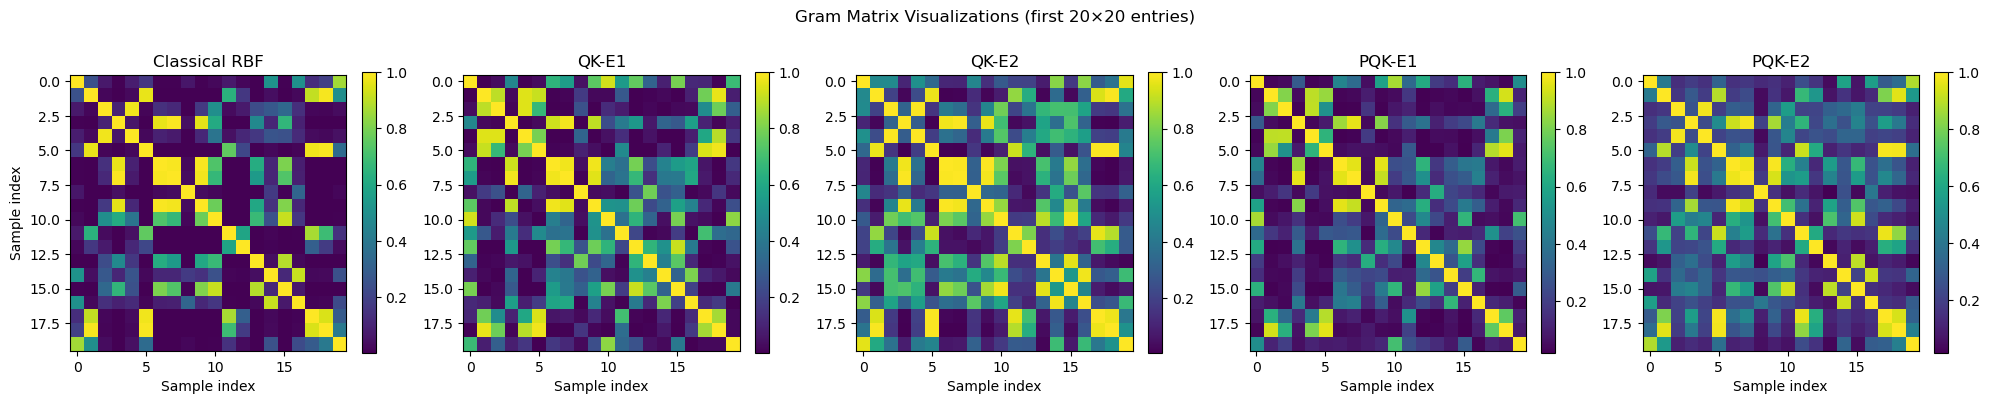

Each matrix shows how similar data points are to each other:
- Brighter colors = higher similarity
- Different patterns indicate different geometries


In [4]:
# Visualizing the Gram Matrices
import matplotlib.pyplot as plt

# Visualize first 20x20 subset of each Gram matrix for clarity
subset_size = 20
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

matrices = [K_classical, K_quantum_E1, K_quantum_E2, K_pqk_E1, K_pqk_E2]
titles = ['Classical RBF', 'QK-E1', 'QK-E2', 'PQK-E1', 'PQK-E2']

for i, (K, title) in enumerate(zip(matrices, titles)):
    im = axes[i].imshow(K[:subset_size, :subset_size], cmap='viridis', aspect='equal')
    axes[i].set_title(title)
    axes[i].set_xlabel('Sample index')
    if i == 0:
        axes[i].set_ylabel('Sample index')
    plt.colorbar(im, ax=axes[i], fraction=0.046)

plt.tight_layout()
plt.suptitle(f'Gram Matrix Visualizations (first {subset_size}×{subset_size} entries)', y=1.02)
plt.show()

print("Each matrix shows how similar data points are to each other:")
print("- Brighter colors = higher similarity")
print("- Different patterns indicate different geometries")

In [5]:
# We then compute the practitioner’s metric g for each quantum kernel, according to the formula used in the paper by Huang et al.
from scipy.linalg import sqrtm

def compute_g(K_classical, K_quantum, eps=1e-7):
    """
    Compute geometric difference g between classical and quantum kernels.
    Formula: g = sqrt( || sqrt(K_quantum) @ inv(K_classical) @ sqrt(K_quantum) || )
    """
    N = K_classical.shape[0]

    # Regularize and invert K_classical
    Kc_reg = K_classical + eps * np.eye(N)
    Kc_inv = np.linalg.inv(Kc_reg)

    # Compute the square root of the quantum kernel
    sqrt_Kq = sqrtm(K_quantum)
    # Construct M = sqrt(Kq) @ Kc⁻¹ @ sqrt(Kq)
    M = sqrt_Kq @ Kc_inv @ sqrt_Kq

    # g = sqrt(max eigenvalue of M)
    max_eigval = np.max(np.linalg.eigvalsh(M))
    return np.sqrt(np.maximum(max_eigval, 0.0))

# Compute g for all four quantum kernels
g_QK_E1   = compute_g(K_classical, K_quantum_E1)
g_QK_E2   = compute_g(K_classical, K_quantum_E2)
g_PQK_E1  = compute_g(K_classical, K_pqk_E1)
g_PQK_E2  = compute_g(K_classical, K_pqk_E2)

# Display results
print("\n--- Geometric Difference (g) ---")
print(f"g (RBF vs QK‑E1):    {g_QK_E1:.4f}")
print(f"g (RBF vs QK‑E2):    {g_QK_E2:.4f}")
print(f"g (RBF vs PQK‑E1):   {g_PQK_E1:.4f}")
print(f"g (RBF vs PQK‑E2):   {g_PQK_E2:.4f}")


--- Geometric Difference (g) ---
g (RBF vs QK‑E1):    8.3359
g (RBF vs QK‑E2):    2.1493
g (RBF vs PQK‑E1):   894.0699
g (RBF vs PQK‑E2):   194.6228


### What does a high $g$ really tell us?

We can see that in terms of $g$:

PQK-E1 > PQK-E2 > QK-E1 > QK-E2.

A common misconception is that a higher geometric difference $g$ automatically means better classification performance, which might lead us to believe, for example, that in terms of final accuracy, the ranking will also be PQK-E1 > PQK-E2 > QK-E1 > QK-E2.

This intuition is understandable — after all, a larger $g$ suggests that the quantum kernel perceives the data very differently from a classical one.  
But as we'll see, **a higher $g$ doesn't always translate into better accuracy, it just means there's higher potential for an improvement over the classical model**.

In fact, a higher $g$ can sometimes correspond to worse performance on the original task.


Let's see this in action.

In [6]:
# We train SVMs using each kernel and compare test accuracy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel

def train_evaluate_svm(K_train, K_test, y_train, y_test, name):
    print(f"Training SVM with {name} kernel...")
    clf = SVC(kernel="precomputed")
    clf.fit(K_train, y_train)
    acc = accuracy_score(y_test, clf.predict(K_test))
    print(f"  Test accuracy: {acc:.4f}")
    return acc

results = {}

# Classical RBF
K_rbf_test = rbf_kernel(X_test, X_train)
results["Classical RBF"] = train_evaluate_svm(K_classical, K_rbf_test, y_train, y_test, "Classical RBF")

# Quantum Kernel E1
K_qk_e1_test = qml.kernels.kernel_matrix(X_test, X_train, lambda x, y: overlap_prob(x, y, embedding_E1))
results["QK-E1"] = train_evaluate_svm(K_quantum_E1, K_qk_e1_test, y_train, y_test, "Quantum E1")

# Quantum Kernel E2
K_qk_e2_test = qml.kernels.kernel_matrix(X_test, X_train, lambda x, y: overlap_prob(x, y, embedding_E2))
results["QK-E2"] = train_evaluate_svm(K_quantum_E2, K_qk_e2_test, y_train, y_test, "Quantum E2")

# PQK E1
pauli_test_E1 = get_pauli_vectors(embedding_E1, X_test)
gamma_E1 = calculate_gamma(np.vstack((get_pauli_vectors(embedding_E1, X_train), pauli_test_E1)))
K_pqk_e1_test = rbf_kernel(pauli_test_E1, get_pauli_vectors(embedding_E1, X_train), gamma=gamma_E1)
results["PQK-E1"] = train_evaluate_svm(K_pqk_E1, K_pqk_e1_test, y_train, y_test, "PQK E1")

# PQK E2
pauli_test_E2 = get_pauli_vectors(embedding_E2, X_test)
gamma_E2 = calculate_gamma(np.vstack((get_pauli_vectors(embedding_E2, X_train), pauli_test_E2)))
K_pqk_e2_test = rbf_kernel(pauli_test_E2, get_pauli_vectors(embedding_E2, X_train), gamma=gamma_E2)
results["PQK-E2"] = train_evaluate_svm(K_pqk_E2, K_pqk_e2_test, y_train, y_test, "PQK E2")

# Summary
print("\n--- Accuracy Comparison ---")
for model, acc in results.items():
    print(f"{model:>15}: {acc:.4f}")

Training SVM with Classical RBF kernel...
  Test accuracy: 0.9111
Training SVM with Quantum E1 kernel...
  Test accuracy: 0.8333
Training SVM with Quantum E2 kernel...
  Test accuracy: 0.8444
Training SVM with PQK E1 kernel...
  Test accuracy: 0.8333
Training SVM with PQK E2 kernel...
  Test accuracy: 1.0000

--- Accuracy Comparison ---
  Classical RBF: 0.9111
          QK-E1: 0.8333
          QK-E2: 0.8444
         PQK-E1: 0.8333
         PQK-E2: 1.0000


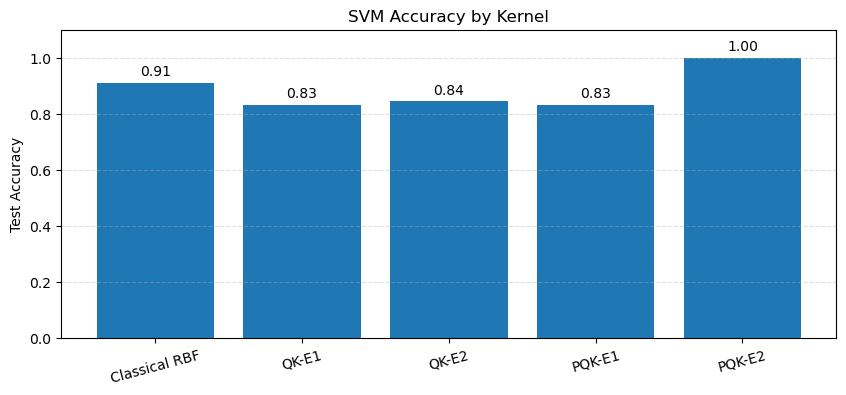

In [7]:
# Accuracy Comparison

import matplotlib.pyplot as plt

# Extract model names and accuracies
model_names = list(results.keys())
accuracies = [results[name] for name in model_names]

# Create bar chart
plt.figure(figsize=(10,4))
bars = plt.bar(model_names, accuracies)
plt.ylim(0, 1.10)
plt.ylabel("Test Accuracy")
plt.title("SVM Accuracy by Kernel")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Annotate values
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.015, f"{acc:.2f}", ha='center', va='bottom')

plt.show()

Our test results reveal an important subtlety:  
**A higher geometric difference $g$ does *not* guarantee better classification accuracy.**

For instance:
- **PQK‑E2** achieved perfect test accuracy ($100\%$), despite having a lower $g$ than PQK‑E1.

This highlights a key message from the paper:  
> The role of $g$ is *not* to predict which kernel will perform best on a given task — but rather to obtain a collection of kernels that have the *potential* to offer an advantage.

Here, PQK-E1 and PQK-E2 both had the potential for an advantage over classical, but PQK-E2 is the only one that actually achieved the advantage. As a simple practical rule, if $g$ is low, then we can immediately discard a quantum kernel, whereas if $g$ is high, we keep the kernel as a potential solution because it offers a potential for an improvement on our classification problem. This way, we have an important diagnostic tool to filter out  bad quantum kernels for our data.


### 🧠 Conclusion: A Practical Perspective on the Geometric Difference $g$

In this notebook, we explored a fundamental question in quantum machine learning:

> **Can we anticipate, *before training*, whether a quantum kernel might outperform a classical one?**

To address this, we used the **geometric difference $g$**, a pre-training metric introduced by Huang et al. that quantifies how *differently* a quantum kernel organizes the data compared to a classical kernel.

---

### 🔑 Key takeaways:

- **$g$ is a diagnostic, not a performance predictor.**  
  A large $g$ indicates that the quantum kernel induces a very different geometry from the classical one — a *necessary*, but not *sufficient*, condition for quantum advantage.

- **Higher $g$ does not imply higher accuracy.**  
  In our results, **PQK‑E2** had a high $g$ and achieved perfect accuracy — but **PQK‑E1**, with a higher $g$, obtained a lower accuracy on the original task. This confirms that $g$ measures *potential*, not realized performance.

- **$g$'s value is in ruling out unpromising kernels.**  
  Kernels with very small $g$ are unlikely to offer any meaningful advantage over classical methods—meaning the quantum kernel introduces no genuinely new distinctions beyond what a classical RBF can produce. By contrast, a high $g$ only tells us that *some advantage may be possible* — not that it will be realized.

## Appendix: What if We Take the Labels Into Account?

The cells above explore the importance of $g$ in a practical setting. However, as an appendix, we also present a construction from the paper that's pretty fun to play around with. We mentioned that a high $g$ does not necessarily mean that a quantum kernel will outperform a classical kernel, such as the case of PQK-E1. This is because $g$ does not take the dataset *labels* into account in a supervised learning setting (such as the SVM we are exploring in the paper), and it could be that the specific labels we have are not a good fit for the geometry of the kernel. The authors proposed a method to artificially construct new labels that align with a quantum kernel's geometry. This guarantees that if $g$ is large enough, we will get an improvement since both the input features and labels now match the geometry of the kernel. This is a toy construction; it's not practical because we usually care about the actual dataset labels we have rather than the fake labels, but it's good for getting more intuition about the role of $g$ and why it sometimes fails in predicting performance. 

### How Label Re-engineering Works:

Given $K_Q$ and $K_C$, the process generates new labels that maximize quantum kernel advantage:

1. Compute the matrix $M = \sqrt{K_Q}(K_C)^{-1}\sqrt{K_Q}$
2. Find the eigenvector $v$ corresponding to the largest eigenvalue $g^2$ of $M$
3. Project this eigenvector through $\sqrt{K_Q}$ to get new continuous labels: $y = \sqrt{K_Q}v$
4. Binarize using the median as threshold to create classification labels

The new labels match the geometry of $K_Q$ and provide an advantage which is proportional to $g$.

Let's do this!

In [8]:
# Engineer labels for PQK-E1
# ---------------------------------------------------------------------------#
# Rebuild full X, y used in kernel computations #
# ---------------------------------------------------------------------------#
X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([y_train, y_test])
n_samples = X_all.shape[0]
# ---------------------------------------------------------------------------#
# Recompute kernels on full dataset #
# ---------------------------------------------------------------------------#
print("Recomputing QK‑E1 and classical kernel on full dataset...")
K_qk_E1_full = quantum_kernel_matrix(X_all, embed=embedding_E1)
K_classical_full = rbf_kernel(X_all)
# ---------------------------------------------------------------------------#
# Generate engineered labels using eigendecomposition of quantum kernel
# ---------------------------------------------------------------------------#
print("Generating engineered labels to favor QK‑E1...")
# Compute matrix square roots and inverse
KQ_sqrt = sqrtm(K_qk_E1_full)
KC_reg = K_classical_full + 1e-7 * np.eye(K_classical_full.shape[0])
KC_inv = np.linalg.inv(KC_reg)

# Solve eigenvalue problem: √KQ(KC)^(-1)√KQ
M = KQ_sqrt @ KC_inv @ KQ_sqrt
eigvals, eigvecs = np.linalg.eigh(M)
v_max = eigvecs[:, -1]  # Largest eigenvalue's eigenvector

# Apply square root transformation: y = √KQ v
y_engineered_continuous = KQ_sqrt @ v_max

# Threshold at median to create binary labels
median_val = np.median(y_engineered_continuous)
label_low, label_high = np.min(y_all), np.max(y_all)
y_engineered = np.where(y_engineered_continuous > median_val, label_high, label_low).astype(y_all.dtype)
print("✅ Engineered labels generated successfully.")
print(f"Class {label_low}: {np.sum(y_engineered == label_low)}")
print(f"Class {label_high}: {np.sum(y_engineered == label_high)}")
# -----------------------------------------------------------------------#
# Resplit into train/test using original index split #
# -----------------------------------------------------------------------#
y_train_eng = y_engineered[:len(y_train)]
y_test_eng = y_engineered[len(y_train):]

Recomputing QK‑E1 and classical kernel on full dataset...
Generating engineered labels to favor QK‑E1...
✅ Engineered labels generated successfully.
Class 0: 150
Class 1: 150


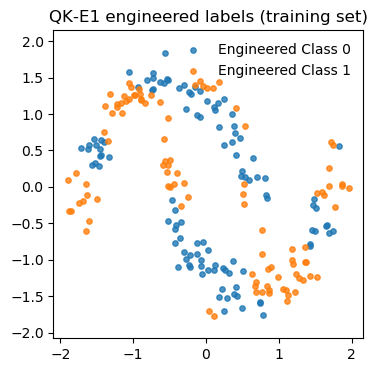

In [9]:
# We plot the newly re-engineered dataset for PQK-E1

plt.figure(figsize=(4, 4))
plt.scatter(X_train[y_train_eng == 0, 0], X_train[y_train_eng == 0, 1],
            s=15, alpha=0.8, label="Engineered Class 0")
plt.scatter(X_train[y_train_eng == 1, 0], X_train[y_train_eng == 1, 1],
            s=15, alpha=0.8, label="Engineered Class 1")
plt.axis("equal")
plt.title("QK‑E1 engineered labels (training set)")
plt.legend(frameon=False)
plt.show()

In [10]:
# We train SVMs using each kernel and compare test accuracy on the new engineered labels.
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel

results_engineered = {}

# Classical RBF
K_rbf_test = rbf_kernel(X_test, X_train)
results_engineered["Classical RBF"] = train_evaluate_svm(K_classical, K_rbf_test, y_train_eng, y_test_eng, "Classical RBF")

# Quantum Kernel E1
K_qk_e1_test = qml.kernels.kernel_matrix(X_test, X_train, lambda x, y: overlap_prob(x, y, embedding_E1))
results_engineered["QK-E1"] = train_evaluate_svm(K_quantum_E1, K_qk_e1_test, y_train_eng, y_test_eng, "Quantum E1")

# Quantum Kernel E2
K_qk_e2_test = qml.kernels.kernel_matrix(X_test, X_train, lambda x, y: overlap_prob(x, y, embedding_E2))
results_engineered["QK-E2"] = train_evaluate_svm(K_quantum_E2, K_qk_e2_test, y_train_eng, y_test_eng, "Quantum E2")

# PQK E1
pauli_test_E1 = get_pauli_vectors(embedding_E1, X_test)
gamma_E1 = calculate_gamma(np.vstack((get_pauli_vectors(embedding_E1, X_train), pauli_test_E1)))
K_pqk_e1_test = rbf_kernel(pauli_test_E1, get_pauli_vectors(embedding_E1, X_train), gamma=gamma_E1)
results_engineered["PQK-E1"] = train_evaluate_svm(K_pqk_E1, K_pqk_e1_test, y_train_eng, y_test_eng, "PQK E1")

# PQK E2
pauli_test_E2 = get_pauli_vectors(embedding_E2, X_test)
gamma_E2 = calculate_gamma(np.vstack((get_pauli_vectors(embedding_E2, X_train), pauli_test_E2)))
K_pqk_e2_test = rbf_kernel(pauli_test_E2, get_pauli_vectors(embedding_E2, X_train), gamma=gamma_E2)
results_engineered["PQK-E2"] = train_evaluate_svm(K_pqk_E2, K_pqk_e2_test, y_train_eng, y_test_eng, "PQK E2")

# Summary
print("\n--- Accuracy Comparison (Engineered Labels) ---")
for model, acc in results_engineered.items():
    print(f"{model:>15}: {acc:.4f}")

Training SVM with Classical RBF kernel...
  Test accuracy: 0.6111
Training SVM with Quantum E1 kernel...
  Test accuracy: 0.8667
Training SVM with Quantum E2 kernel...
  Test accuracy: 0.6222
Training SVM with PQK E1 kernel...
  Test accuracy: 0.8667
Training SVM with PQK E2 kernel...
  Test accuracy: 0.7444

--- Accuracy Comparison (Engineered Labels) ---
  Classical RBF: 0.6111
          QK-E1: 0.8667
          QK-E2: 0.6222
         PQK-E1: 0.8667
         PQK-E2: 0.7444


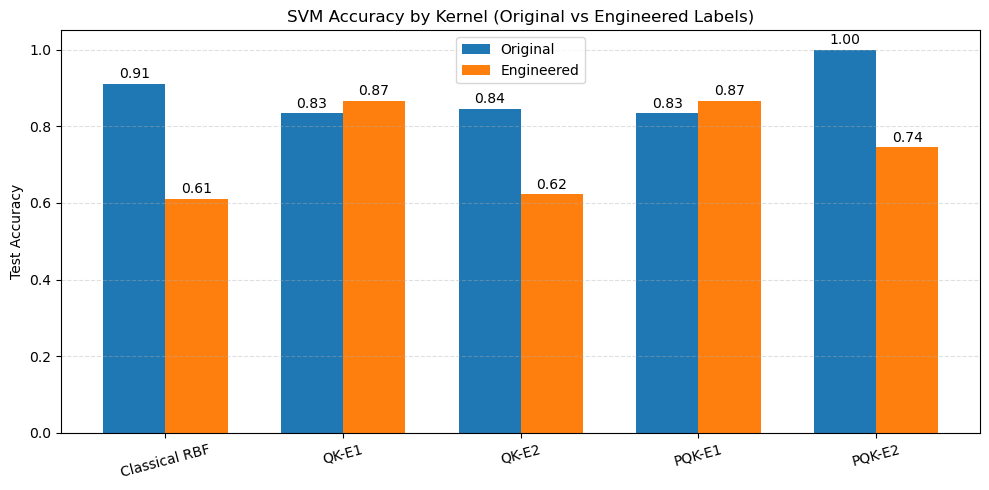

In [11]:
# Accuracy Comparison — Side-by-Side Bars (Original vs Engineered) for PQK-E1

import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
x = np.arange(len(model_names))  # the label locations
width = 0.35  # width of each bar

# Get accuracy values
acc_orig = [results[name] for name in model_names]
acc_eng  = [results_engineered[name] for name in model_names]

# Plot
plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - width/2, acc_orig, width, label='Original', color='tab:blue')
bars2 = plt.bar(x + width/2, acc_eng,  width, label='Engineered', color='tab:orange')

# Labels and ticks
plt.ylabel("Test Accuracy")
plt.title("SVM Accuracy by Kernel (Original vs Engineered Labels)")
plt.xticks(x, model_names, rotation=15)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()

# Annotate bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.015, f"{yval:.2f}", ha='center')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.015, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()
